In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from glm.glm import GLM
from glm.families import Gaussian, Bernoulli, Poisson, Gamma


import statsmodels.formula.api as smf
from helper_functions import linear_model_summary


%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Predictive Linear Regression 

Based on Dan Rupp's Lecture

### The task of predicting quantities: in story form

Let's start a business: **we estimate the fuel economy of cars.** People describe a car and pay us money, and we tell them the fuel economy (in miles per gallon) of their car.

* The first customer comes in, and says, "This is a very competitive field. Why should we pay you?"
* You say, "We are very good at what we do."
* They say, "Your competitor says the same thing. Do you have evidence?"

Note two things.
1. **You are competing against other models.**
2. **Your model will be evaluated quantitatively.**

So you say: "We have analyzed all of our competitors's predictions. All their predictions have some error; the mean of their predictive errors is 5 mpg. We can do better."

* Them: "Ah, interesting. Prove it."
* You: "Describe a car."
* Them: "A 2020 hybrid Ford F250"
* You: "Can't predict - that **that car isn't in our records**"
* Them: "What good is that?"
* You: "If you ask about an old car, we can predict it perfectly."
* Them: "And...why would we pay for that?"
* You: "I don't know, but we are perfect."
* Them: "We'll go to your competitor instead."


3. **The only performance that matters is predictive performance on unseen examples.**


### Practical Examples of Linear Regression 

#### Based on the speed of your vehicle, how many feet do you need to move to come to a complete stop?
<img class =“right” src="images/speed_stopping_distance.png" style="width:400px;height:300px;">

#### How does advertising dollars spent effect a companies profits?
<img class="left" src="images/Marketing_v_sales.gif" style="width:400px;height:300px;">




What are the X-axis and Y-axis?   

What does the line represent?   

### A linear regression:
 - Is a linear combination of coefficents and attributes.  Each coefficent represents a linear relationship between the feature and the target.
 
 For stopping distance:
 $$
 \hat{y_i} = -10 + (18 \times distance)
 $$
 
 For Advertising:
 $$
 \hat{y_i} = 110 + (2 \times add\_dollars)
 $$

<img src="images/Linear_Regression_coefficients.png"> <!-- style="width:800px;height:400px;"> -->

### Terminology:   

- **Dependent Variable** (dependent, target, $y$) - The value you are trying to predict or investigate.   
- **Independent Variable** (values, features, $X$) - The data you are using to try to predict the target.
    - Single observations of the independent variable/variables are denoted with the lower case $x$
- **Fitting a Model** - For linear regression this is finding the line that best fits the training data.    
- **Training Data** - Observations used to train a model (linear regression).   
- **Prediction**  ( $\hat{y}$  ) - An estimation of the target

# Linear Regression

<p>
Models can be used for many purposes.  For the majority of the course, we focus on using models as predictive tools.  In those cases, getting the correct answer is more important than the information that the model avails to us, and as such, we are able to use models of increasing complexity (at the cost of transparency).  
</p>

<h2>An Initial Relationship.</h2>
<p>
We may intuitively know that smaller cars get better gas milage. Much less intuitive is the size of the effect, and how much this effect describes the difference in gas milage from car to car.
</p>

## Loading and Inspecting the Data

For our example we will use a dataset dataset about various specimens of single species of insect collected across two continents.  The data was acquired from this question on CrossValidated, a statistics/data science question and answer site:

[Multiple regression, full and restricted model](http://stats.stackexchange.com/q/267034/74500)

We chose this dataset because it is small enough to be accessible, but has some interesting features for us to discover!

We will be interested in explaining how the insects wing span varies, as influenced by the other measurements in our dataset.

We'd like to load the `insects` data into python.  Our first step is to take a quick look at the raw data.

In [32]:
plt.style.use('ggplot')

In [33]:
!head ./data/insects.csv

continent	latitude	wingsize	sex
1	40.5	941.111111111	0
1	42.0	924.444444444	0
1	43.6	924.204444444	0
1	45.7	915.217777778	0
1	45.9	905.471111111	0
1	47.4	896.004444444	0
1	50.0	913.0	0
1	51.8	916.44	0
1	53.8	933.417777778	0


It looks like there are four columns in our dataset:

```
continent, latitude, wingsize, and sex
```

Each data element is separated from the next by a tab character, so although it has the `.csv` extension, it is not comma separated.

In [34]:
insects = pd.read_csv('./data/insects.csv', sep='\t')
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


In [5]:
insects.tail()

,continent,latitude,wingsize,sex
37,0,47.3,818.240000,1
38,0,48.5,856.000000,1
39,0,50.4,842.071111,1
40,0,52.1,820.960000,1
41,0,56.1,855.537778,1


In [35]:
{ col:insects[col].unique() for col in insects.columns if col in ['continent', 'sex']}
# insects.sex.unique()

# d = {}
# for col in insects.columns:
#     if col in ['continent', 'sex']:
#         d[col] = insects[col].unique()
# d

{'continent': array([1, 0]), 'sex': array([0, 1])}

We've got our four columns `continent, latitude, wingsize, and sex`.  

We can see some short descriptions of their qualities using `info`:

In [36]:
insects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   continent  42 non-null     int64  
 1   latitude   42 non-null     float64
 2   wingsize   42 non-null     float64
 3   sex        42 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.4 KB


## Looking at the Data

We can get a first feel for how the quantities in our data are spread out using some histograms.

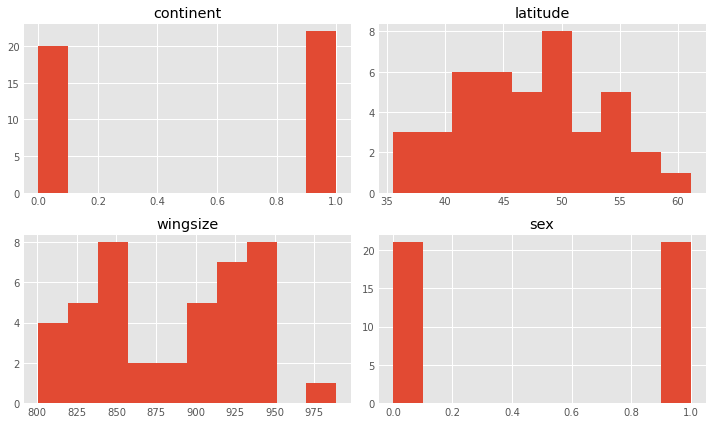

In [37]:

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for ax, column in zip(axs.flatten(), insects.columns):
    ax.hist(insects[column])
    ax.set_title(column)

fig.tight_layout()

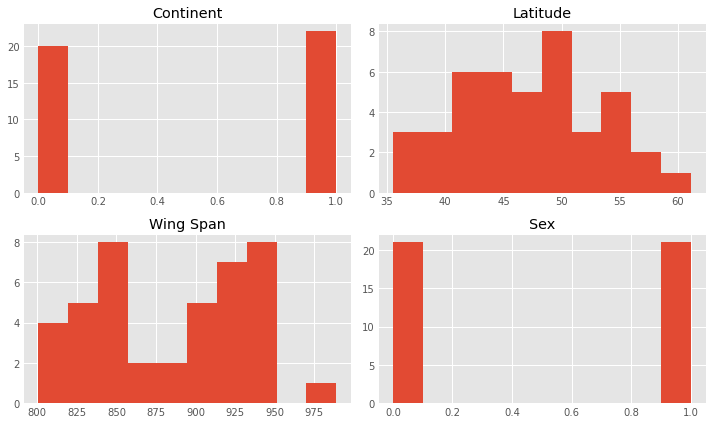

In [38]:
column_names = {
    "continent": "Continent",
    "latitude": "Latitude",
    "wingsize": "Wing Span",
    "sex": "Sex"
}

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for ax, (column, name) in zip(axs.flatten(), column_names.items()):
    ax.hist(insects[column])
    ax.set_title(name)

fig.tight_layout()

**Discussion:** What have you learned form the data from these histograms?  How do they help you describe the data?

Some observations:

  - `continent` and `sex` take only two values.  There are two continents represented in the data, labeled zero and one, and there are two sexes (probably Male and Female), also labeled zero and one.
  
These zero/one columns are called **binary** or **indicator variables**, they measure a specific yes/no condition.

  - The values of `wingspan` cluster into two distinct groups.  This is very interesting, and worthy of investigation.

## Scatterplots

Histograms are useful, but limited, as they do not reveal anything about the *relationships between the columns in our data*.  To rectify this we turn to uncountably the most effective and flexible visualization, the **scatterplot**.

A good first step is to use `pandas.plotting.scatter_matrix` to get a global view of our data.

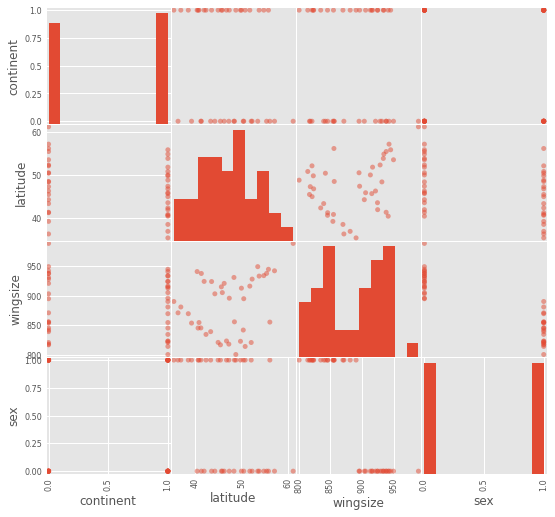

In [39]:
scatter_matrix(insects, figsize=(8, 8), s=100);
plt.show()

The `latitude` vs. `wingsize` scatterplot looks interesting, so let's take a close look at that.

Text(0.5, 1.0, 'Insect Wing Sizes at Various Latitudes')

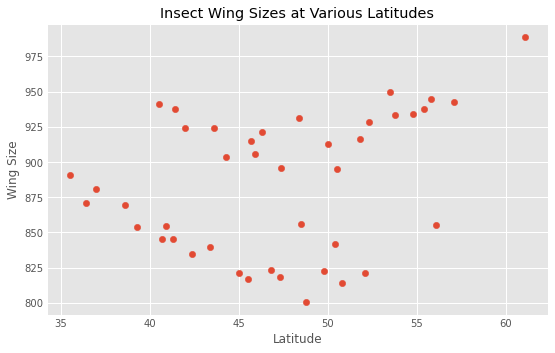

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(insects.latitude, insects.wingsize, s=40)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")

**Discussion:** What patterns do you see in the scatterplot.  Can you form any hypothesis about the data?

Here are some thoughts:
    
  - The most prominent feature of this data is the two bands.  There seem to be two very well defined elongated clusters of data, with the average wingsize in one cluster much greater than in the other.
  - Within each cluster there is noticeable tendency for wingsize first decrease, and then increase as latitude varies.

## Linear Regression

This leads to a few questions we may wish to answer with the data.

  1. Are the two clusters associated with one of the other two variables in the dataset, `continent` or `sex?`
  2. Can we somehow summarize the way that `wingsize` varies with `latitude`?
  
Let's answer each of these questions.

### Are The Two Clusters Associated With Either Continent or Sex?

We can discover if the two clusters in the data are associated with either `continent` or `sex` through a well chosen visualization.  Let's make the same scatterplot from before, but color each point either red or blue, according to the value of `continent` or `sex`.

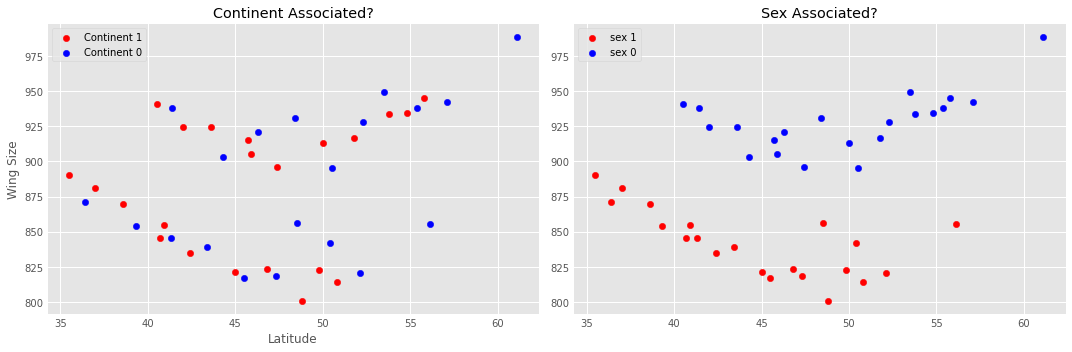

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True)

continent_boolean = insects.continent.astype(bool)
ax[0].scatter(insects.latitude[continent_boolean], insects.wingsize[continent_boolean], 
           s=40, c="red", label="Continent 1")
ax[0].scatter(insects.latitude[~continent_boolean], insects.wingsize[~continent_boolean],
           s=40, c="blue", label="Continent 0")
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Wing Size")
ax[0].set_title("Continent Associated?")
ax[0].legend()


sex_boolean = insects.sex.astype(bool)
ax[1].scatter(insects.latitude[sex_boolean], insects.wingsize[sex_boolean], 
           s=40, c="red", label="sex 1")
ax[1].scatter(insects.latitude[~sex_boolean], insects.wingsize[~sex_boolean],
           s=40, c="blue", label="sex 0")
ax[1].set_title("Sex Associated?")
ax[1].legend()



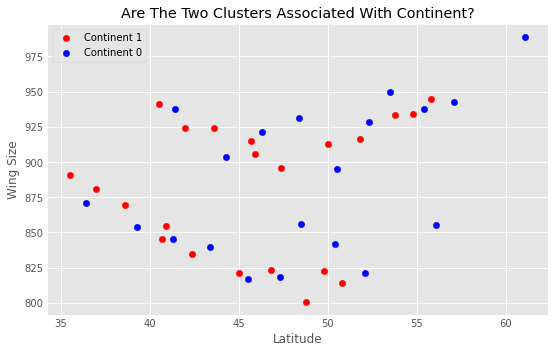

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

continent_boolean = insects.continent.astype(bool)
ax.scatter(insects.latitude[continent_boolean], 
           insects.wingsize[continent_boolean], 
           s=40, c="red", label="Continent 1")
ax.scatter(insects.latitude[~continent_boolean], 
           insects.wingsize[~continent_boolean],
           s=40, c="blue", label="Continent 0")
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Are The Two Clusters Associated With Continent?")
ax.legend()

The values of continent seem scattered randomly across the two clusters, so it does **not** seem like continent is associated with the clusters.

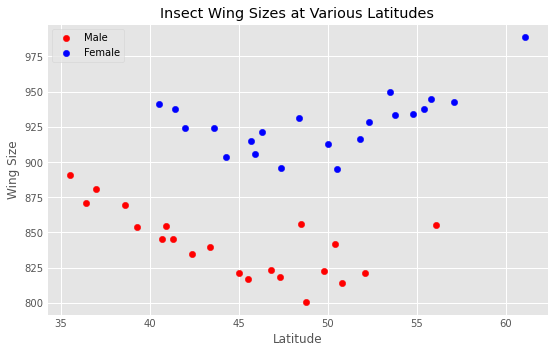

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))

def make_insects_scatter_plot(ax):
    sex_boolean = insects.sex.astype(bool)
    ax.scatter(insects.latitude[sex_boolean], 
               insects.wingsize[sex_boolean],
               s=40, c="red", label="Male")
    ax.scatter(insects.latitude[~sex_boolean], 
               insects.wingsize[~sex_boolean],
               s=40, c="blue", label="Female")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_scatter_plot(ax)

Consider the visual from our last lecture on Cross Validation. Notice we always come back to buisness understanding and data understanding. If you first build a model without basic eda and statistical investigations we likely miss concepts like this. 

<img src="images/800px-CRISP-DM_Process_Diagram.png" alt="Drawing" style="width: 400px;"/>

There we go!

This is pretty definitive, the cluster of the larger insects are all female, and the cluster of smaller insects are all male.  This seems like enough evidence to conclude that the sex of the insect causes the data to cluster into two groups.

**Note:** how little technology we needed to make this point convincingly.  It is *very important* to explore your data and use it to *ask and then answer* question like this.  Many data scientists reach immediately for their most powerful tools, which often leaves them with little to say when asked simple questions.

### Is An Increasing Latitude Associated With an Increasing Wing Size?

This question is a little more sophisticated, and we need some new technology to answer it.

The idea is to create an equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} $$

Then we can look at the number $b$, which tells us how we should expect `wingspan` to change as `latitude` changes.  If we find that $b > 0$, that's evidence that an increasing latitude is associated with an increasing wingspan.

So we can use Linear Regression

In [44]:
import statsmodels.api as sm


Please note that we are adding the constant here so we get an intercept term.

In [45]:
X = sm.add_constant(insects['latitude'])
y = insects['wingsize']

In [46]:
X.head()

,const,latitude
0,1.0,40.5
1,1.0,42.0
2,1.0,43.6
3,1.0,45.7
4,1.0,45.9


In [47]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.595
Date:                Fri, 30 Apr 2021   Prob (F-statistic):             0.0382
Time:                        21:05:48   Log-Likelihood:                -220.17
No. Observations:                  42   AIC:                             444.3
Df Residuals:                      40   BIC:                             447.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        765.1966     56.276     13.597      0.000     651.458     878.935
latitude       2.5400      1.185      2.144      0.038       0.145       4.935
==============================================================================
Omnibus:                        7.752   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                3.189
Skew:                          -0.380   Prob(JB):                        0.203
Kurtosis:                       1.884   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
results.params

const       765.196573
latitude      2.539958
dtype: float64

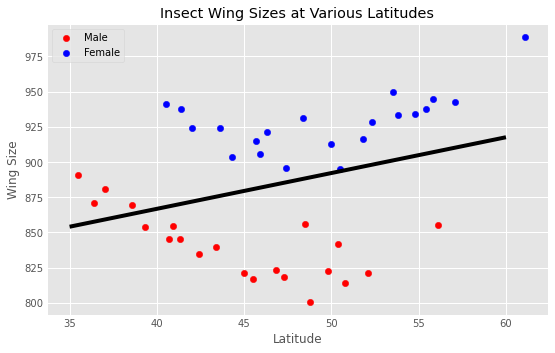

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))

make_insects_scatter_plot(ax)
xx = np.linspace(35,60,100)
y_hat = results.params['const'] + (results.params['latitude'] * xx)

ax.plot(xx, y_hat, c='black')

The linear regression has attempted to estimate the equation we are after, and it has returned:

$$ \text{Wing Span} \approx 765.20 + 2.54 \times \text{Latitude} $$

So we can expect an on average increase of $2.54$ wingspan for every increase in one latitude.

The numbers estimated in linear regression are called **parameter estimates** or **coefficient estimates** and are usually denoted with the Greek letter $\beta$:

$$y \approx \beta_0 + \beta_1 x $$

The parameter estimate with no associated variable is usually called the **intercept**:

$$ \text{Wing Span} \approx \underbrace{765.20}_{\text{Intercept}} + \underbrace{2.54}_{\text{Parameter Estiamte}} \times \text{Latitude} $$


#### As the Equation of a Line

One way we can visualize this is to look at the regression as returning to us the equation for a line.  This line is the **best summary of the data** (under the assumption that a line is a reasonable way to summarize the data).

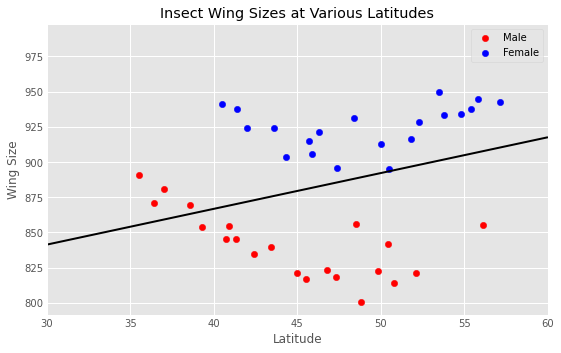

In [54]:
#This is from a old library to do lin regression.  Do not worry about it.
linear_model = GLM(family=Gaussian())
linear_model.fit(insects, formula='wingsize ~ latitude')


fig, ax = plt.subplots(figsize=(8, 5))

make_insects_scatter_plot(ax)

# Make a line graph of the predictions.
def make_insects_model_line(ax, label="Linear Regression"):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, linear_model.coef_[0] + linear_model.coef_[1] * x,
           linewidth=2, c="black", label=label)
    ax.set_xlim(30, 60)

make_insects_model_line(ax)

**Discussion:** Does this model have any issues?  If so, what are they?

This plot shows two serious flaws in our model:

  - It has no knowledge of the sex of the insect, so the fit line attempts to bisect the two clusters of data.
  - It cannot account for the curvature in the data points.  The model attempts to fit a line to data that does not have a linear shape.

## Accounting for the Sex of the Insect: Binary Predictors

It would much better to take account of the sex of the index and fit two lines, we make one line of prediction of the wing size given the latitude for males, and another for females.

The easiest way to do this is to modify our equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Sex} $$

There is now another term: if the insect is male we *add $c$* to the prediction, otherwise we add nothing.


In [55]:
X = sm.add_constant(insects[['latitude','sex']])
y = insects['wingsize']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     75.12
Date:                Fri, 30 Apr 2021   Prob (F-statistic):           4.21e-14
Time:                        21:31:45   Log-Likelihood:                -189.29
No. Observations:                  42   AIC:                             384.6
Df Residuals:                      39   BIC:                             389.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        948.2463     31.665     29.947      0.000     884.199    1012.294
latitude      -0.4120      0.630     -0.653      0.517      -1.687       0.863
sex          -88.0281      7.699    -11.434      0.000    -103.600     -72.456
==============================================================================
Omnibus:                        3.802   Durbin-Watson:                   0.890
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.698
Skew:                           0.587   Prob(JB):                        0.259
Kurtosis:                       3.404   Cond. No.                         432.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A couple of points are important:

- We now have an estimate for the number $c$ of $-88.03$.  This means, that on average, being male costs an insect about $-88.03$ in wingspan.
- The parameter estimates for the `Intercept` and for `latitude` **have changed**.  This is a very common situation.  When we fit a model with multiple variables, the model accounts for both how the variables are related to $y$, **and** how they are related to **each other**.

The predictions from this model now depend on whether an insect is male or female, meaning that we can draw one line for males, and one line for females.

$$
\text{Wing Span} \approx 948.25 + -0.41 \times \text{Latitude} + -88.03 \times \text{Sex}
$$
<br/>
<br/>
<br/>
The calculation for female:
$$
\text{Wing Span} \approx 948.25 + -0.41 \times \text{Latitude} + -88.03 \times 0
$$
or:
$$
\text{Wing Span} \approx 948.25 + -0.41 \times \text{Latitude}
$$
<br/>
<br/>
<br/>
<br/>
For male:
$$
\text{Wing Span} \approx 948.25 + -0.41 \times \text{Latitude} + -88.03 \times 1
$$
or:
$$
\text{Wing Span} \approx 948.25 + -0.41 \times \text{Latitude}+ -88.03 
$$

## This is important when thinking about inferential regression
- The better the model in inferential regression the better the coefficients 

In [56]:
results.params

const       948.246289
latitude     -0.411968
sex         -88.028092
dtype: float64

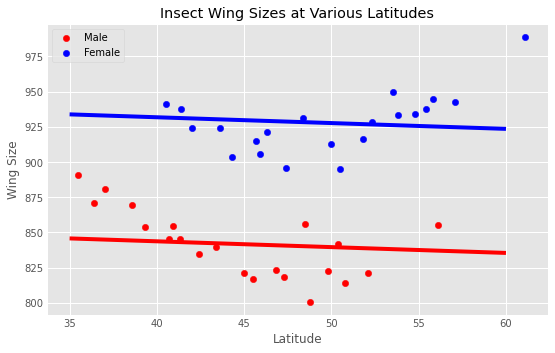

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))

make_insects_scatter_plot(ax)
xx = np.linspace(35,60,100)
y_hat_male = results.params['const'] + (results.params['latitude'] * xx) + (results.params['sex'] *0)

y_hat_female = results.params['const'] + (results.params['latitude'] * xx) + (results.params['sex'] *1)


ax.plot(xx, y_hat_male, c='blue')
ax.plot(xx, y_hat_female, c='red')

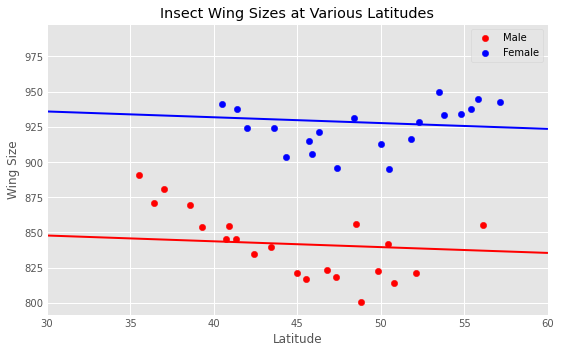

In [63]:

insects_model_with_sex = GLM(family=Gaussian())
insects_model_with_sex.fit(insects, formula='wingsize ~ latitude + sex')

fig, ax = plt.subplots(figsize=(8, 5))

make_insects_scatter_plot(ax)

def make_insects_model_lines(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_with_sex.coef_[0] 
                 + insects_model_with_sex.coef_[1] * x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_with_sex.coef_[0] 
                 + insects_model_with_sex.coef_[1] * x + insects_model_with_sex.coef_[2],
           linewidth=2, c="red")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_lines(ax)

The model is now fitting much better to the data, but the curvature of the scatterplots is still an issue.

## Accounting for the Curvature of the Data Points: Transformations

We can account for the curvature of the data points by using a *polynomial regression*.  This means that we fit powers of latitude bigger than one:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} $$

In [139]:
X = insects[['latitude','sex']]
X['latitude**2'] = X['latitude']**2
X = sm.add_constant(X)

y = insects['wingsize']

X.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,const,latitude,sex,latitude**2
0,1.0,40.5,0,1640.25
1,1.0,42.0,0,1764.00
2,1.0,43.6,0,1900.96
3,1.0,45.7,0,2088.49
4,1.0,45.9,0,2106.81


In [140]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     245.6
Date:                Fri, 30 Apr 2021   Prob (F-statistic):           6.48e-25
Time:                        23:02:50   Log-Likelihood:                -159.14
No. Observations:                  42   AIC:                             326.3
Df Residuals:                      38   BIC:                             333.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1946.8863     91.875     21.191      0.000    1760.895    2132.878
latitude      -43.2140      3.893    -11.101      0.000     -51.094     -35.334
sex           -89.4629      3.807    -23.499      0.000     -97.170     -81.756
latitude**2     0.4513      0.041     11.031      0.000       0.368       0.534
==============================================================================
Omnibus:                        5.109   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.052
Skew:                           0.508   Prob(JB):                        0.132
Kurtosis:                       4.133   Cond. No.                     1.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
results.params

const          1946.886344
latitude        -43.214023
sex             -89.462873
latitude**2       0.451328
dtype: float64

''

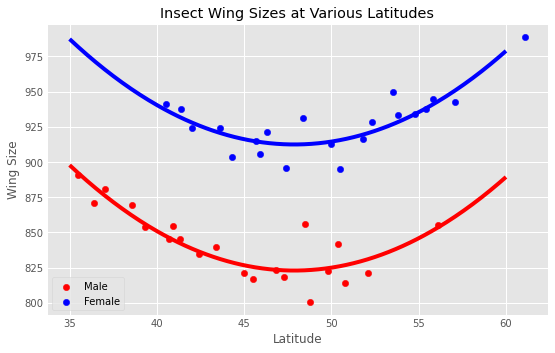

In [143]:
fig, ax = plt.subplots(figsize=(8, 5))

make_insects_scatter_plot(ax)
xx = np.linspace(35,60,250)
y_hat_male = results.params['const'] + (results.params['latitude'] * xx)  
+ (results.params['latitude**2'] * xx * xx) + (results.params['sex'] *0)

y_hat_female = results.params['const'] + (results.params['latitude'] * xx)  
+ (results.params['latitude**2'] * xx * xx) + (results.params['sex'] *1)


ax.plot(xx, results.params['const'] 
        + (results.params['latitude'] * xx)  
        + (results.params['latitude**2'] * xx * xx) 
        + (results.params['sex'] *0),
        c='blue')
ax.plot(xx, results.params['const'] 
        + (results.params['latitude'] * xx)  
        + (results.params['latitude**2'] * xx * xx) 
        + (results.params['sex'] *1), c='red')
;


In [96]:
insects_model_quad.coef_

array([ 1.94688634e+03, -4.32140235e+01,  4.51328021e-01, -8.94628734e+01])

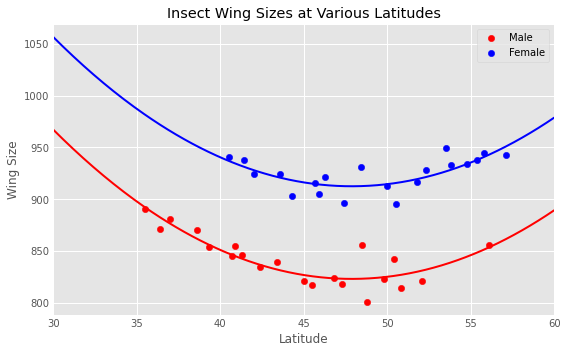

In [88]:
insects_model_quad = GLM(family=Gaussian())
insects_model_quad = linear_model.fit(
    insects, 
    formula='wingsize ~ latitude + I(latitude**2) + sex')

fig, ax = plt.subplots(figsize=(8, 5))

# Make a scatterplot of the data.
make_insects_scatter_plot(ax)

def make_insects_model_quadratic(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_quad.coef_[0] 
                 + insects_model_quad.coef_[1] * x
                 + insects_model_quad.coef_[2] * x*x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_quad.coef_[0] 
                 + insects_model_quad.coef_[1] * x
                 + insects_model_quad.coef_[2] * x*x
                 + insects_model_quad.coef_[3],
           linewidth=2, c="red")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_quadratic(ax)

Now we have a good fit to our data.

**Discussion:** Should we go further and add higher degree terms into the model?  Why or why not?  What would happen if do?

## How will adding continent change the model?

Now we have four different possible combinations of indicator variables

  - `sex == 0 and continent == 0`
  - `sex == 1 and continent == 0`
  - `sex == 0 and continent == 1`
  - `sex == 1 and continent == 1`
  
Which results in four curves being fit (though the **shape** of the quadratic trend is the same for each, as the parameters associated with latitude are **shared**).

In [109]:
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


In [110]:
insects_model_quad_with_continent = GLM(family=Gaussian())
insects_model_quad_with_continent.fit(
    insects,
    formula='wingsize ~ latitude + I(latitude**2) + sex + continent')
insects_model_quad_with_continent.summary()

Gaussian GLM Model Summary.
Name                 Parameter Estimate  Standard Error
-------------------------------------------------------
Intercept                       1945.39           91.51
latitude                         -42.96            3.88
I(latitude ** 2)                   0.45            0.04
sex                              -89.90            3.81
continent                         -4.11            3.58


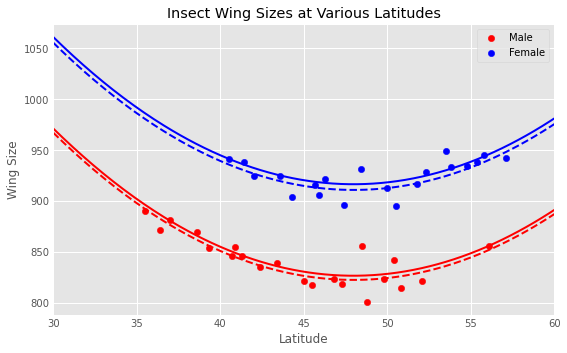

In [111]:
fig, ax = plt.subplots(figsize=(8, 5))

# Make a scatterplot of the data.
make_insects_scatter_plot(ax)

def make_insects_model_quadratic_and_continent(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_quad.coef_[0] 
                 + insects_model_quad_with_continent.coef_[1] * x
                 + insects_model_quad_with_continent.coef_[2] * x*x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_quad_with_continent.coef_[0] 
                 + insects_model_quad_with_continent.coef_[1] * x
                 + insects_model_quad_with_continent.coef_[2] * x*x
                 + insects_model_quad_with_continent.coef_[4],
           linewidth=2, c="blue", linestyle="--")
    ax.plot(x, insects_model_quad.coef_[0] 
                 + insects_model_quad_with_continent.coef_[1] * x
                 + insects_model_quad_with_continent.coef_[2] * x*x
                 + insects_model_quad_with_continent.coef_[3],
           linewidth=2, c="red")
    ax.plot(x, insects_model_quad.coef_[0] 
                 + insects_model_quad_with_continent.coef_[1] * x
                 + insects_model_quad_with_continent.coef_[2] * x*x
                 + insects_model_quad_with_continent.coef_[3]
                 + insects_model_quad_with_continent.coef_[4],
           linewidth=2, c="red", linestyle="--")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_quadratic_and_continent(ax)

The effect of the `continent` variable is seen here as the difference between the solid and dashed lines.  It's evident from this plot that `continent` is not very useful in describing the `wingsize` of our insects.

## How about categorical fields that are not binary?
 - You have a survey with feed back options:
   * 1) Poor
   * 2) Fair
   * 3) Good
   * 4) Excellent    
<br/>
  <br/>      
 - You have a field with eye color:
   * 1) Brown
   * 2) Green 
   * 3) Blue
   * 4) Grey
   

### How may we handle the `origin` field in the cars dataset?

In [112]:
cars = pd.read_csv('data/cars_multivariate.csv', na_values=['?'])
cars = cars[cars.horsepower.notnull()]
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


We can create binary indicators as to if it is of a given origin

In [113]:
pd.get_dummies(cars['origin'], prefix='origin')

,origin_1,origin_2,origin_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
393,1,0,0
394,0,1,0
395,1,0,0
396,1,0,0


Do I need all three indicator columns?

In [114]:
pd.get_dummies(cars['origin'], prefix='origin', drop_first=True)

,origin_2,origin_3
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
393,0,0
394,1,0
395,0,0
396,0,0


## Important note. 
Many times it is useful to look at our 'residuals' after making a model to see what they look like.

In [124]:
# Create a linear regression object
X = cars['weight']
X = sm.add_constant(X)
y = cars['mpg']

regressor = sm.OLS(y,X)
regressor = regressor.fit()
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     878.8
Date:                Fri, 30 Apr 2021   Prob (F-statistic):          6.02e-102
Time:                        22:28:53   Log-Likelihood:                -1130.0
No. Observations:                 392   AIC:                             2264.
Df Residuals:                     390   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2165      0.799     57.867      0.000      44.646      47.787
weight        -0.0076      0.000    -29.645      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       41.682   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.039
Skew:                           0.727   Prob(JB):                     9.18e-14
Kurtosis:                       4.251   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

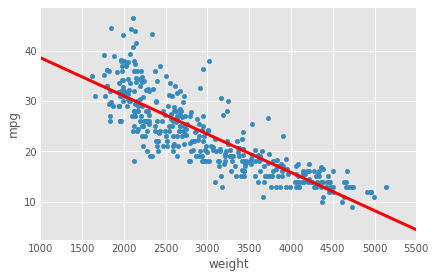

In [125]:
# Plot the line along with the data
slope = -.0076
intercept = 46.2165
ax = cars.plot('weight','mpg',kind='scatter')
xx = np.linspace(1000, 5500, 100)
ax.plot(xx, xx*slope + intercept, color='red', lw=3)
ax.set_xlim([1000,5500]);

### Many times when modeling the resudals plots will be informative

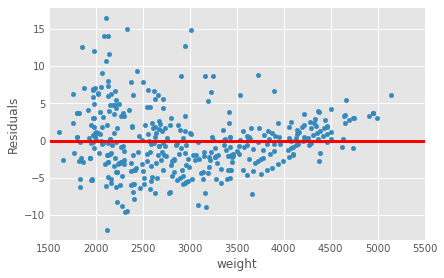

In [126]:
X["y_hat"] = regressor.predict(X)
X["Residuals"] = y - X["y_hat"]
# Plot the line along with the data
ax = X.plot('weight','Residuals',kind='scatter')
ax.plot(xx, [0]*100, color='red', lw=3)
_ = ax.set_xlim([1500,5500])

In [128]:
np.sum(X.Residuals**2)

7321.233706188365

In [120]:
X.head()

,const,weight,y_hat,Residuals
0,1.0,3504.0,19.420236,-1.420236
1,1.0,3693.0,17.974889,-2.974889
2,1.0,3436.0,19.940256,-1.940256
3,1.0,3433.0,19.963198,-3.963198
4,1.0,3449.0,19.840840,-2.840840


In [129]:
X_sq = pd.DataFrame({'weight' : cars['weight'], 'weight_sq' : cars['weight']**2})
X_sq = sm.add_constant(X_sq)

reg_sq = sm.OLS(y, X_sq).fit()
reg_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     488.3
Date:                Fri, 30 Apr 2021   Prob (F-statistic):          8.39e-107
Time:                        22:31:22   Log-Likelihood:                -1115.1
No. Observations:                 392   AIC:                             2236.
Df Residuals:                     389   BIC:                             2248.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.2555      2.993     20.800      0.000      56.371      68.140
weight        -0.0185      0.002     -9.379      0.000      -0.022      -0.015
weight_sq   1.697e-06   3.06e-07      5.545      0.000     1.1e-06     2.3e-06
==============================================================================
Omnibus:                       53.804   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.923
Skew:                           0.809   Prob(JB):                     4.03e-21
Kurtosis:                       4.770   Cond. No.                     1.57e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [130]:
X_sq.head()

,const,weight,weight_sq
0,1.0,3504.0,12278016.0
1,1.0,3693.0,13638249.0
2,1.0,3436.0,11806096.0
3,1.0,3433.0,11785489.0
4,1.0,3449.0,11895601.0


In [132]:
reg_sq.params

const        62.255474
weight       -0.018496
weight_sq     0.000002
dtype: float64

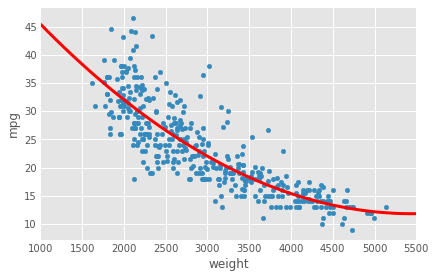

In [131]:
# Plot the line along with the data
slope = -.0185
slope_sq = 1.697e-6
intercept = 62.255


ax = cars.plot('weight','mpg',kind='scatter')
xx = np.linspace(1000, 5500, 100)
ax.plot(xx, xx*xx*slope_sq + xx*slope + intercept, color='red', lw=3)
_ = ax.set_xlim([1000,5500])

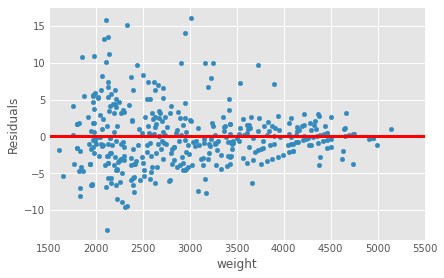

In [133]:
X_sq["y_hat"] = reg_sq.predict(X_sq)
X_sq["Residuals"] = y - X_sq["y_hat"]


# Plot the line along with the data
ax = X_sq.plot('weight','Residuals',kind='scatter')
ax.plot(xx, [0]*100, color='red', lw=3)
_ = ax.set_xlim([1500,5500])

In [134]:
np.sum(X_sq.Residuals**2)

6784.898508507804

In [135]:
y.shape

(392,)

In [136]:
X_sq['Residuals'].shape

(392,)

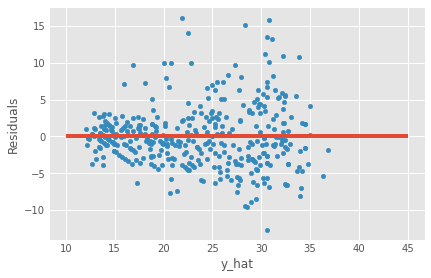

In [137]:
X_sq['y'] = y

# Plot the line along with the data
ax = X_sq.plot('y_hat','Residuals',kind='scatter')
ax.hlines(0,10,45)


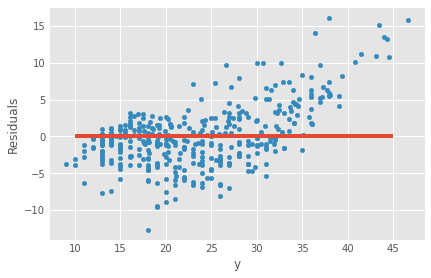

In [138]:
# Plot the line along with the data
ax = X_sq.plot('y','Residuals',kind='scatter')
ax.hlines(0,10,45)
